In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from category_encoders import TargetEncoder

from tensorflow.keras.metrics import Mean
from tensorflow.keras.losses import Loss
from tensorflow.python.ops.math_ops import log, cast, squared_difference, sqrt, \
    div_no_nan
from tensorflow.python.keras.utils import losses_utils
from tensorflow.keras import backend
from tensorflow import constant, math

pd.options.display.max_rows = 80

# Load dataset

In [14]:
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)
y_test = test['SalePrice']
test.drop('SalePrice', axis=1, inplace=True)
categorical_features =\
    ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
     'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
     'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
     'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
     'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
     'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir',
     'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
     'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
     'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']

# Fill missing data

In [15]:
def fill_na(dataset):
    dataset['LotFrontage'].fillna(dataset['LotFrontage'].mean(), inplace=True)
    dataset['Electrical'].fillna('SBrkr', inplace=True)
    dataset['Functional'].fillna('Typ', inplace=True)
    dataset['KitchenQual'].fillna('TA', inplace=True)
    dataset['MSZoning'].fillna('RL', inplace=True)
    dataset['SaleType'].fillna('WD', inplace=True)
    dataset['Utilities'].fillna('AllPub', inplace=True)
    dataset['Exterior1st'].fillna('Wd Sdng', inplace=True)
    dataset['Exterior2nd'].fillna('MetalSd', inplace=True)
    dataset['PoolQC'].fillna('Gd', inplace=True)
    categorical_na = 'No'
    # Alley
    dataset['Alley'].fillna(categorical_na, inplace=True)
    dataset['GarageYrBlt'].fillna(0, inplace=True)
    dataset['GarageYrBlt'].replace(2207, 2007, inplace=True)
    dataset['GarageCars'].fillna(0, inplace=True)
    dataset['GarageArea'].fillna(0, inplace=True)

    dataset['PoolQC'].fillna(categorical_na, inplace=True)
    dataset['Fence'].fillna(categorical_na, inplace=True)
    dataset['MiscFeature'].fillna(categorical_na, inplace=True)
    dataset['FireplaceQu'].fillna(categorical_na, inplace=True)

    dataset['MasVnrType'].fillna(categorical_na, inplace=True)
    dataset['MasVnrArea'].fillna(0, inplace=True)

    # Basement
    basement_categorical = ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
                            'BsmtCond', 'BsmtExposure']
    dataset[basement_categorical] = dataset[
        basement_categorical].fillna(
        categorical_na)

    basement_numerical = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
                          'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
    dataset[basement_numerical] = dataset[basement_numerical].fillna(0)

    # Garage
    garage_categorical = ['GarageType', 'GarageFinish', 'GarageQual',
                          'GarageCond']
    dataset[garage_categorical] = dataset[garage_categorical].fillna(categorical_na)
    return dataset
train = fill_na(train)
test = fill_na(test)
dataset_full = pd.concat([train, test])

# Feature engineering

In [16]:
def generate_manual_features(X):
    new_categorical_features = []
    X_manual = X.copy()

    X_manual['BuildingAge'] = X_manual['YrSold'] - X_manual['YearBuilt']
    X_manual['BuildingAge'] = np.where(X_manual['BuildingAge'] > 0,
                                       X_manual['BuildingAge'], 0)

    X_manual['RemodelledAge'] = X_manual['YrSold'] - X_manual[
        'YearRemodAdd']
    X_manual['RemodelledAge'] = np.where(X_manual['RemodelledAge'] > 0,
                                         X_manual['RemodelledAge'], 0)
    X_manual['GarageAge'] = np.where(X_manual['GarageYrBlt'] == 0, 0,
                                     X_manual['YrSold'] - X_manual[
                                         'GarageYrBlt'])
    X_manual['GarageAge'] = np.where(X_manual['GarageAge'] < 0, 0,
                                     X_manual['GarageAge'])

    X_manual['Year'] = X_manual['YrSold'].map(
        {2006: 1, 2007: 2, 2008: 3, 2009: 4, 2010: 5})
    new_categorical_features.append('Year')

    X_manual['BeforeCrisis'] = np.where(X_manual['YrSold'] < 2010, 1, 0)
    new_categorical_features.append('BeforeCrisis')

    # TotalAreaSF
    X_manual['TotalAreaSF'] = X_manual['GrLivArea'] \
                              + X_manual['TotalBsmtSF']
    ########################################################################
    # BasementUnFinished
    X_manual['BasementFinishedPercent'] = \
        (X_manual['TotalBsmtSF'] - X_manual['BsmtUnfSF']) / X_manual[
            'TotalBsmtSF']
    X_manual['BasementFinishedPercent'].fillna(0, inplace=True)
    ########################################################################
    # 7. Bin the data if required
    bin_features = ['TotalAreaSF']

    # X_binned = X_manual.copy()
    result = pd.cut(X_manual['TotalAreaSF'], bins=30, right=True).cat.codes
    result = np.array(result).reshape(-1, 1)
    X_manual['TotalAreaSFBinned'] = result

    # X_manual = bin_data(X_manual, bin_features, 30, new_columns=False,
    #                     replace=False)
    # X_manual.rename(columns={'TotalAreaSF_binned': 'TotalAreaSFBinned'},
    #                 inplace=True)
    new_categorical_features.append('TotalAreaSFBinned')
    ########################################################################
    # Storeys
    floors = {20: 1, 30: 1, 40: 1, 45: 1, 50: 1, 60: 2, 70: 2, 75: 2, 80: 2,
              85: 2, 90: 2, 120: 1, 150: 1, 160: 2, 180: 2, 190: 2}
    X_manual['Floors'] = X_manual['MSSubClass'].map(floors)
    new_categorical_features.append('Floors')
    ########################################################################
    # Turn some categorical features into numerical features
    condition_dict = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0,
                      'No': 0}

    X_manual['ExterQualNum'] = X_manual['ExterQual'].map(condition_dict)
    X_manual['ExterCondNum'] = X_manual['ExterCond'].map(condition_dict)
    X_manual['BsmtQualNum'] = X_manual['BsmtQual'].map(condition_dict)
    X_manual['BsmtCondNum'] = X_manual['BsmtCond'].map(condition_dict)
    X_manual['HeatingQCNum'] = X_manual['HeatingQC'].map(condition_dict)
    X_manual['KitchenQualNum'] = X_manual['KitchenQual'].map(condition_dict)
    X_manual['FireplaceQuNum'] = X_manual['FireplaceQu'].map(condition_dict)
    X_manual['GarageQualNum'] = X_manual['GarageQual'].map(condition_dict)
    X_manual['PoolQCNum'] = X_manual['PoolQC'].map(condition_dict)
    X_manual['GarageCondNum'] = X_manual['GarageCond'].map(condition_dict)

    condition_dict = {'Gd': 3, 'Av': 2, 'Mn': 1, 'NA': 0, 'No': 0,
                      'No Basement': 0}
    X_manual['BsmtExposureNum'] = X_manual['BsmtExposure'].map(
        condition_dict)
    condition_dict = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2,
                      'Unf': 1, 'NA': 0, 'No': 0}

    X_manual['BsmtFinType1Num'] = X_manual['BsmtFinType1'].map(condition_dict)

    X_manual['BsmtFinType2Num'] = X_manual['BsmtFinType2'].map(
        condition_dict)

    condition_dict = {'Fin': 3, 'RFn': 2, 'Unf': 1, 'No': 0, 'NA': 0}
    X_manual['GarageFinishNum'] = X_manual['GarageFinish'].map(
        condition_dict)

    condition_dict = {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, 'No': 0}
    X_manual['FenceNum'] = X_manual['Fence'].map(condition_dict)

    ########################################################################
    X_manual['OverallQualOverallCond'] = X_manual['OverallQual'] + X_manual[
        'OverallCond']

    X_manual['RoomSize'] = X_manual['GrLivArea'] + X_manual['TotRmsAbvGrd']

    X_manual['SumAge'] = (X_manual['BuildingAge'] + X_manual[
        'RemodelledAge'])

    X_manual['OverallQualTotalAreaSFMultiplied'] = X_manual['OverallQual'] \
                                                   * X_manual['TotalAreaSF']
    X_manual['QualSquared'] = \
        np.square(X_manual['OverallQual'].astype(np.int64))

    ########################################################################
    # Sort the features list
    new_categorical_features = sorted(new_categorical_features)
    ########################################################################

    return X_manual,new_categorical_features
dataset_full, new_categorical_features = \
    generate_manual_features(dataset_full)

In [17]:
replaced_features = \
    ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
     'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
     'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence']
dataset_full.drop(replaced_features, axis=1, inplace=True)
for feature in replaced_features:
    categorical_features.remove(feature)
dataset_full

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,BsmtExposureNum,BsmtFinType1Num,BsmtFinType2Num,GarageFinishNum,FenceNum,OverallQualOverallCond,RoomSize,SumAge,OverallQualTotalAreaSFMultiplied,QualSquared
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,No,Reg,Lvl,AllPub,Inside,...,0,6,1,2,0,12,1718,10,17962.0,49
2,20,RL,80.0,9600,Pave,No,Reg,Lvl,AllPub,FR2,...,3,5,1,2,0,14,1268,62,15144.0,36
3,60,RL,68.0,11250,Pave,No,IR1,Lvl,AllPub,Inside,...,1,6,1,2,0,12,1792,13,18942.0,49
4,70,RL,60.0,9550,Pave,No,IR1,Lvl,AllPub,Corner,...,0,5,1,1,0,12,1724,127,17311.0,49
5,60,RL,84.0,14260,Pave,No,IR1,Lvl,AllPub,FR2,...,2,6,1,2,0,13,2207,16,26744.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,No,Reg,Lvl,AllPub,Inside,...,0,1,1,0,0,11,1097,72,6552.0,16
2916,160,RM,21.0,1894,Pave,No,Reg,Lvl,AllPub,Inside,...,0,3,1,1,0,9,1098,72,6552.0,16
2917,20,RL,160.0,20000,Pave,No,Reg,Lvl,AllPub,Inside,...,0,5,1,1,0,12,1231,56,12240.0,25


# Feature encoding

In [18]:
columns_to_encode = categorical_features
encoder = TargetEncoder(cols=columns_to_encode)
dataset_full_enc = encoder.fit_transform(dataset_full[columns_to_encode],
                                       dataset_full['SalePrice'])
for column in columns_to_encode:
    dataset_full[column + 'MeanEncoded'] = dataset_full_enc[column]

dataset_full.drop(categorical_features, axis=1, inplace=True)

c:\python\portfolio\new_venv\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [19]:
train_mask = dataset_full['SalePrice'].isna() == False
pred_mask = dataset_full['SalePrice'].isna() == True

dataset_encoded = dataset_full[train_mask]
dataset_pred_encoded = dataset_full[pred_mask]

In [20]:
X = dataset_encoded.drop('SalePrice', axis=1)
y = dataset_encoded['SalePrice']

X_pred = dataset_pred_encoded.drop('SalePrice', axis=1)
y_pred = dataset_pred_encoded['SalePrice']

In [21]:
X_pred['MSSubClassMeanEncoded'] = X_pred['MSSubClassMeanEncoded'].fillna(
    X_pred['MSSubClassMeanEncoded'].mean())

# Feature scaling

In [22]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X), columns=X.columns,
                       index=X.index)
X_test = pd.DataFrame(scaler.transform(X_pred), columns=X_pred.columns,
                       index=X_pred.index)
y_train = y

# Create custom metric and loss functions

In [23]:
class RootMeanSquaredLogErrorScaledLoss(Loss):

    def __init__(self, name='rmsle_custom_loss', dtype='float32', scaler=None):
        super(RootMeanSquaredLogErrorScaledLoss, self).__init__(name=name)
        # if scaler:
        self.scaler = scaler
        self.dtype = dtype

    def call(self, y_true, y_pred):
        y_true = cast(y_true, self.dtype)
        y_pred = cast(y_pred, self.dtype)
        if isinstance(self.scaler, StandardScaler):
            sc_mean = constant(self.scaler.mean_, self.dtype)
            sc_std = constant(self.scaler.scale_, self.dtype)
            y_true = y_true * sc_std + sc_mean
            y_pred = y_pred * sc_std + sc_mean
        elif isinstance(self.scaler, MinMaxScaler):
            sc_min = constant(self.scaler.min_, self.dtype)
            sc_scale = constant(self.scaler.scale_, self.dtype)
            y_true = (y_true - sc_min) / sc_scale
            y_pred = (y_pred - sc_min) / sc_scale

        y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
            y_pred, y_true)
        pred_log = log(backend.maximum(y_pred, backend.epsilon()) + 1.)
        true_log = log(backend.maximum(y_true, backend.epsilon()) + 1.)
        error_sq = squared_difference(pred_log, true_log)
        return sqrt(math.reduce_mean(error_sq))

class RootMeanSquaredLogErrorScaled(Mean):

    def __init__(self, name='rmsle_custom_metric', dtype='float32',
                 scaler=None):
        super(RootMeanSquaredLogErrorScaled, self).__init__(name, dtype=dtype)
        self.scaler = scaler
        # self.dtype = dtype
        # self.min = tf.constant(min, self._dtype)
        # self.scale = tf.constant(scale, self._dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        """Accumulates root mean squared error statistics.
        Args:
          y_true: The ground truth values.
          y_pred: The predicted values.
          sample_weight: Optional weighting of each example. Defaults to 1. Can be a
            `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
            be broadcastable to `y_true`.
        Returns:
          Update op.
        """
        y_true = cast(y_true, self.dtype)
        y_pred = cast(y_pred, self.dtype)
        if isinstance(self.scaler, StandardScaler):
            sc_mean = constant(self.scaler.mean_, self.dtype)
            sc_std = constant(self.scaler.scale_, self.dtype)
            y_true = y_true * sc_std + sc_mean
            y_pred = y_pred * sc_std + sc_mean
        elif isinstance(self.scaler, MinMaxScaler):
            sc_min = constant(self.scaler.min_, self.dtype)
            sc_scale = constant(self.scaler.scale_, self.dtype)
            y_true = (y_true - sc_min) / sc_scale
            y_pred = (y_pred - sc_min) / sc_scale

        y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
            y_pred, y_true)
        pred_log = log(backend.maximum(y_pred, backend.epsilon()) + 1.)
        true_log = log(backend.maximum(y_true, backend.epsilon()) + 1.)
        error_sq = squared_difference(pred_log, true_log)
        return super(RootMeanSquaredLogErrorScaled, self).update_state(
            error_sq, sample_weight=sample_weight)

    def result(self):
        return sqrt(div_no_nan(self.total, self.count))

def rmsle(y, y_pred):
    if len(y) != len(y_pred):
        return 0
    sum = 0
    for real, pred in zip(y, y_pred):
        # check for negative values
        if real < 0:
            real = 0
        if pred < 0:
            pred = 0
        p = np.log(real + 1)
        r = np.log(pred + 1)
        sum += np.square(p - r)
    result = np.sqrt(sum / len(y_pred))
    if isinstance(result, np.ndarray):
        result = result[0]
    return result


# Use grid search for ANN

In [24]:
from ann_grid_search import AnnGridSearch
grid = {'Epochs': [600],
        'Units': [30, 40, 50],
        'Layers': [3, 5, 8],
        'Loss': [RootMeanSquaredLogErrorScaledLoss()],
        'Metrics': [RootMeanSquaredLogErrorScaled()],
        'ScoreFunc': [rmsle],
        'EarlyStopping': [True],
        'EarlyStoppingMetric':['rmsle_custom_metric'],
        'Patience': [100]}
grid_search = AnnGridSearch(grid)
grid_search.fit(X_train, y_train, X_test, y_test)
grid_search.score(X_test, y_test)

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 00101: early stopping
Epoch 00566: early stopping
Epoch 00353: early stopping
Epoch 00303: early stopping
Epoch 00301: early stopping
Epoch 00101: early stopping


,ModelName,Score
6,Units: 30\nLayers: 8,0.125854
4,Units: 40\nLayers: 5,0.127086
2,Units: 50\nLayers: 3,0.12828
1,Units: 40\nLayers: 3,0.128726
3,Units: 30\nLayers: 5,0.130888
5,Units: 50\nLayers: 5,0.13259
7,Units: 40\nLayers: 8,0.133101
0,Units: 30\nLayers: 3,12.023726
8,Units: 50\nLayers: 8,12.023726


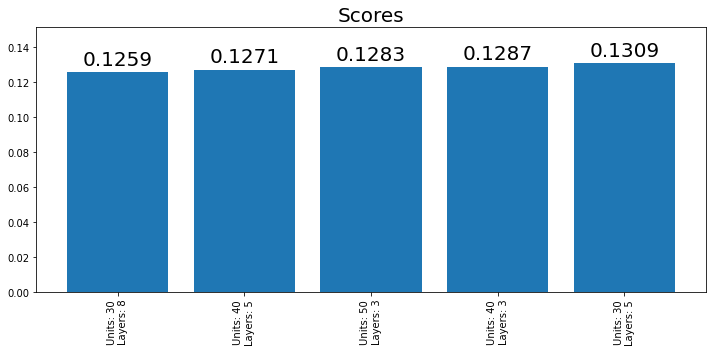

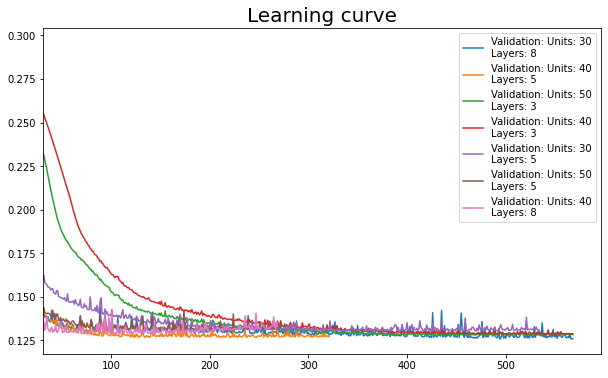

In [25]:
grid_search.score_bar(n_results=5)
grid_search.leaning_curve(val_metric='val_rmsle_custom_metric',
                          strarting_epoch=31, n_results=7)

# Create a submission

In [26]:
def create_submission(X_test, test_pred):
    submission_df = pd.DataFrame({'SalePrice': test_pred.reshape(-1)},
                                 index=X_test.index)
    submission_df.sort_index(inplace=True)
    submission_df.to_csv('Submission.csv', index=True)
    print('Ready!')

In [27]:
create_submission(X_test, grid_search.best_prediction())

Ready!
